In [1]:
import numpy as np
import pandas as pd
import json
import io
import os
import sys
import pickle
import math
import random

import matplotlib.pyplot as plt

In [2]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))

In [3]:
NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

replace_dict = {
    0: 7,
    1: 6,
    2: 5,
    3: 4,
    4: 3,
    5: 2,
    6: 1,
}

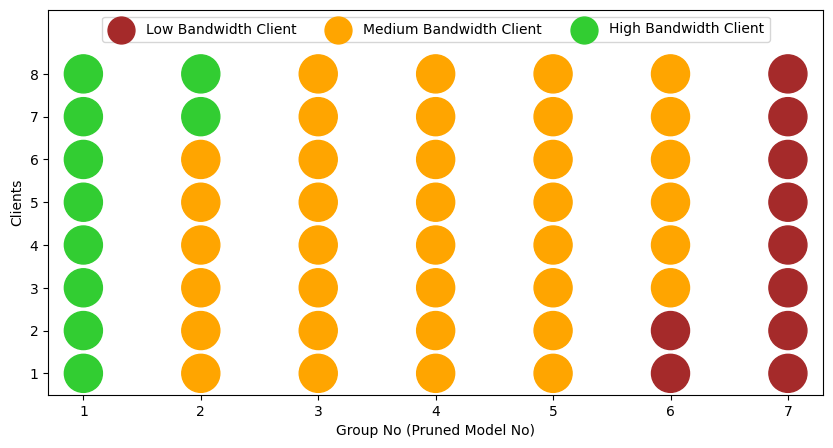

In [4]:
maindf = pd.read_csv("../data/bws_groups.csv", index_col=0)

for idx,row in maindf.iterrows():
    maindf.at[idx,"group"] = replace_dict[row.group]
    maindf.at[idx,"distribution"] = np.array([float(item) for item in row.distribution.replace("[","").replace("]","").split(" ") if item != ""])

def vis_bw_counts(maindf):

    x = np.array(np.meshgrid(np.arange(1,8),np.arange(1,9))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,8),np.arange(1,9))).T.reshape(-1,2)[:,1]
    s = np.ones((7,8))*600
    
    tiers = [[] for i in range(7)]
    for group_name, group_df in maindf.groupby("group"):
        tiers[group_name-1] = group_df["bw_type"].tolist()


    circle_size = 750
    s_low = []
    for group_no in range(7):
        s_low.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "low": size = circle_size
            else: size = 0
            s_low[group_no].append(size)

    s_medium = []
    for group_no in range(7):
        s_medium.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "medium": size = circle_size
            else: size = 0
            s_medium[group_no].append(size)

    s_high = []
    for group_no in range(7):
        s_high.append([])
        for client_no in range(8):
            tier = tiers[group_no][client_no]
            if tier == "high": size = circle_size
            else: size = 0
            s_high[group_no].append(size)


    plt.figure(figsize=(10,5))
    plt.scatter(x, y, s_low,    c="brown",      label="Low Bandwidth Client")
    plt.scatter(x, y, s_medium, c="orange",     label="Medium Bandwidth Client")
    plt.scatter(x, y, s_high,   c="limegreen",  label="High Bandwidth Client")
    plt.legend(loc="upper center", ncol=3)
    plt.ylim(0.5,9.5)
    plt.yticks(np.arange(1,9))
    plt.xlabel("Group No (Pruned Model No)")
    plt.ylabel("Clients")
    plt.show()

vis_bw_counts(maindf)

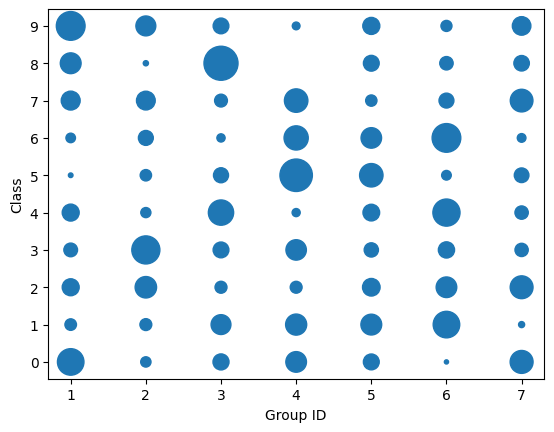

In [5]:
def vis_group_dist(df):

    class_dist = []
    for group_name, group_df in df.groupby("group"):
        class_dist.append(np.sum(group_df.distribution.tolist(),axis=0))
    
    class_dist = np.array(class_dist)

    x = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
    s = class_dist.reshape(1,-1)[0]
    s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*600).astype("int")
    plt.scatter(x,y,s)
    plt.yticks(np.arange(10))
    plt.xlabel("Group ID")
    plt.ylabel("Class")
    plt.show()
    

vis_group_dist(maindf)

[2, 3, 4, 5, 6, 7, 1]
## ITER 0 | No operations done : 7
[3, 4, 5, 6, 7, 1, 2]
## ITER 1 | No operations done : 7
[4, 5, 6, 7, 1, 2, 3]
## ITER 2 | No operations done : 6
[5, 6, 7, 1, 2, 3, 4]
## ITER 3 | No operations done : 4
[6, 7, 1, 2, 3, 4, 5]
## ITER 4 | No operations done : 3
[7, 1, 2, 3, 4, 5, 6]
## ITER 5 | No operations done : 2
[1, 2, 3, 4, 5, 6, 7]
## ITER 6 | No operations done : 1
[2, 3, 4, 5, 6, 7, 1]
## ITER 7 | No operations done : 0


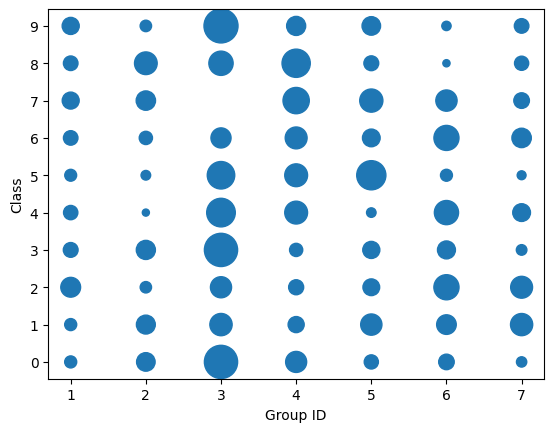

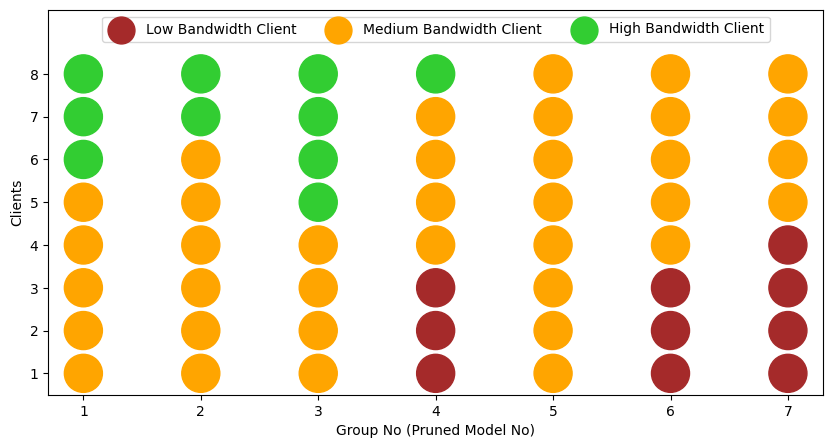

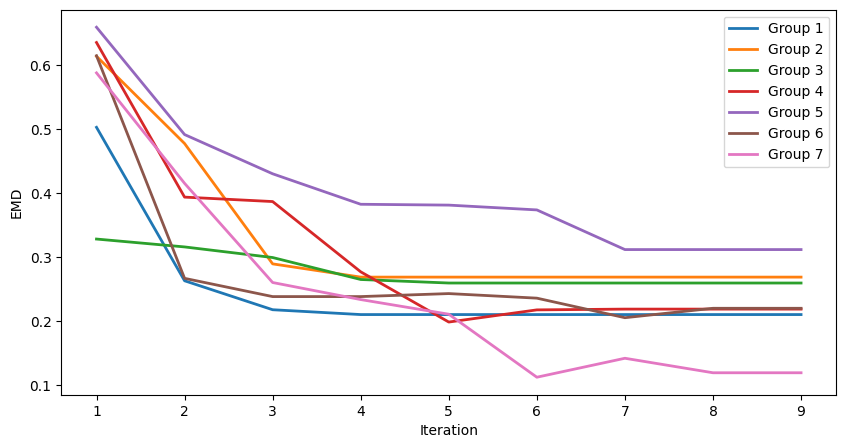

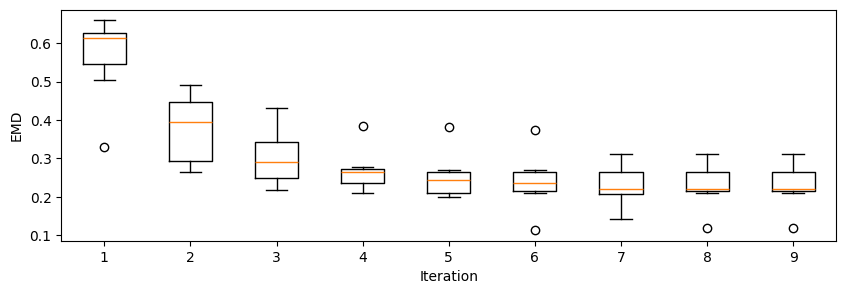

In [9]:
def transfer_op(df_iter, candidate_operations, selected_idx):
    selected_operation = candidate_operations[selected_idx]

    df_dict = df_iter.to_dict(orient="index")
    main_group = df_dict[selected_operation[0]]["group"]
    other_group = df_dict[selected_operation[1]]["group"]

    df_iter.at[selected_operation[0], "group"] = other_group
    df_iter.at[selected_operation[1], "group"] = main_group

    return df_iter

def average_EMD(df_iter, global_dist):
    EMDs = []
    for group_name, group_df in df_iter.groupby("group"):
        EMDs.append(EMD(np.sum(group_df.distribution.values, axis=0), global_dist))
    return np.mean(EMDs)

global_dist = np.sum(maindf.distribution.values, axis=0)
df_iter = maindf.copy()

COEFF = 1.0
all_scores = []
scores = []
emds = []
for group_no in range(NO_GROUPS,0,-1):
    group_selected = df_iter[df_iter["group"] == group_no]
    group_dist = np.sum(group_selected.distribution.values, axis=0)
    scores.append(EMD(group_dist, global_dist))
all_scores.append(scores)


seq_of_move = np.arange(1,NO_GROUPS+1).tolist()

for iter_no in range(10):
    no_operations_done = 0
    # for group_no in range(NO_GROUPS,0,-1):
    # seq_of_move = sorted(np.arange(1,NO_GROUPS+1), key=lambda k: random.random())
    seq_of_move = seq_of_move[1:] + seq_of_move[: 1]
    print(seq_of_move)
    for group_no in seq_of_move:
        current_emd = average_EMD(df_iter, global_dist)
        group_selected = df_iter[df_iter["group"] == group_no]
        
        group_friend_next = df_iter[df_iter["group"] == group_no-1]
        group_friend_prev = df_iter[df_iter["group"] == group_no+1]

        group_friend_next_2 = df_iter[df_iter["group"] == group_no-2]
        group_friend_prev_2 = df_iter[df_iter["group"] == group_no+2]

        candidate_groups = [
            group_friend_next,
            group_friend_prev,
            group_friend_next_2,
            group_friend_prev_2
            ]

        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        score = EMD(group_dist, global_dist)
        candidate_operations = []
        bw_debug = []
        for idx, row in group_selected.iterrows():
            client_id = row.client_id
            group_dist_wo = group_dist - np.array(row.distribution)
            bw_type = row.bw_type

            for candidate_group in candidate_groups:
                for idx2, row2 in candidate_group.iterrows():
                    candidate_dist = group_dist_wo + np.array(row2.distribution)
                    candidate_score = EMD(candidate_dist ,global_dist)
                    bw_type_candidate = row2.bw_type
                    if bw_type == bw_type_candidate: coeff = 1
                    else:
                        # coeff = COEFF**(iter_no+1)
                        coeff = COEFF

                    if candidate_score < score*coeff:

                        df_iter_temp = transfer_op(df_iter.copy(), [(client_id, row2.client_id, candidate_score)], -1)
                        avg_emd = average_EMD(df_iter_temp, global_dist)
                        emds.append(avg_emd)

                        # candidate_operations.append((client_id, row2.client_id, candidate_score))
                        candidate_operations.append((client_id, row2.client_id, avg_emd))
                        bw_debug.append((bw_type, bw_type_candidate))


        # Transfer operation            
        candidate_operations = np.array(candidate_operations)
        if len(candidate_operations) > 0:
            selected_idx = np.argmin(candidate_operations[:,2])
            if current_emd > candidate_operations[selected_idx,2]:
                # print(candidate_operations[selected_idx], bw_debug[selected_idx])
                df_iter = transfer_op(df_iter, candidate_operations, selected_idx)
                no_operations_done += 1

    scores = []
    for group_no in range(NO_GROUPS,0,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
        scores.append(EMD(group_dist, global_dist))
    all_scores.append(scores)

    print(f"## ITER {iter_no} | No operations done : {no_operations_done}")
    if no_operations_done == 0:
        break

vis_group_dist(df_iter)
vis_bw_counts(df_iter)

### EMD CHANGE
all_scores = np.array(all_scores)
ax = plt.subplots(figsize=(10,5))
for group_no in range(NO_GROUPS):
    plt.plot(np.arange(1,len(all_scores)+1), all_scores[:,group_no], label=f"Group {group_no+1}", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("EMD")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.boxplot(all_scores.T)
plt.xlabel("Iteration")
plt.ylabel("EMD")
plt.show()

In [10]:
all_scores[-1]

array([0.21076347, 0.26925288, 0.26002365, 0.21928414, 0.31226484,
       0.22056619, 0.11986773])